# DKGPR

This notebook demonstrates how to use the DKGPR for Microscopy-Spectroscopy

**Author:** Yongtao Liu 

**Date:** Feb 2026

## Import

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Import DKGP
from dkgp import fit_dkgp, predict_dkgpr
from dkgp import (
    expected_improvement,
    upper_confidence_bound,
    probability_of_improvement)

In [3]:
## Helper function

"""The loop area of the hysteresis curve is related to:
 --Strength of ferroelectric switching
 --Energy dissipation during polarization reversal
 --Quality of the ferroelectric material at that location"""

def loop_area(raw_spec, cycle):
    """Calculate loop area from spectrum."""
    raw_spec_len = len(raw_spec)
    cycle_len = int(raw_spec_len / cycle)
    half_len = int(cycle_len / 2)
    q_len = int(cycle_len / 4)
    loop_top, loop_bottom = [], []
    loop_top.append(raw_spec[q_len : q_len + half_len])
    loop_top.append(raw_spec[q_len + 2*half_len : q_len + 3*half_len])
    loop_top.append(raw_spec[q_len + 4*half_len : 2*q_len + 4*half_len])
    loop_bottom.append(raw_spec[:q_len])
    loop_bottom.append(raw_spec[q_len + half_len: q_len + 2*half_len])
    loop_bottom.append(raw_spec[q_len + 3*half_len: q_len + 4*half_len])
    loop_top = np.concatenate(loop_top)
    loop_bottom = np.concatenate(loop_bottom)
    return np.abs(np.sum(loop_top) - np.sum(loop_bottom))

norm_ = lambda x: (x - x.min()) / np.ptp(x)

def get_grid_coords (img, step=1):
    """
    Generate coordinate grid for a single 2D image.
    
    Args:
        img: 2D numpy array
        step: distance between grid points
    
    Returns:
        N x 2 array of (y, x) coordinates
    """
    h, w = img.shape[:2]
    coords = []
    for i in range(0, h, step):
        for j in range(0, w, step):
            coords.append([i, j])
    return np.array(coords)


def get_subimages(img, coordinates, window_size):
    """
    Extract subimages centered at given coordinates.
    
    Args:
        img: 2D or 3D numpy array (h, w) or (h, w, c)
        coordinates: N x 2 array of (y, x) coordinates
        window_size: size of square window to extract
    
    Returns:
        subimages: (N, window_size, window_size, channels) array
        valid_coords: coordinates where extraction succeeded
        valid_indices: indices of valid extractions
    """
    if img.ndim == 2:
        img = img[..., None]
    
    h, w, c = img.shape
    half_w = window_size // 2
    
    subimages = []
    valid_coords = []
    valid_indices = []
    
    for idx, (y, x) in enumerate(coordinates):
        # Check boundaries
        if (y - half_w >= 0 and y + half_w <= h and
            x - half_w >= 0 and x + half_w <= w):
            
            patch = img[y - half_w:y + half_w,
                       x - half_w:x + half_w, :]
            
            if patch.shape[0] == window_size and patch.shape[1] == window_size:
                subimages.append(patch)
                valid_coords.append([y, x])
                valid_indices.append(idx)
    
    return (np.array(subimages), 
            np.array(valid_coords), 
            np.array(valid_indices))

### Load Data

In [4]:
bepsdata = np.load(r"C:\Users\yla\Desktop\BEPS_PTO_1d7um.npz")
amp_off_field = bepsdata['amp_off_field']
pha_off_field = bepsdata['pha_off_field']
v_step = bepsdata['v_step']

pola_off_field = amp_off_field * np.cos(pha_off_field)*1e3

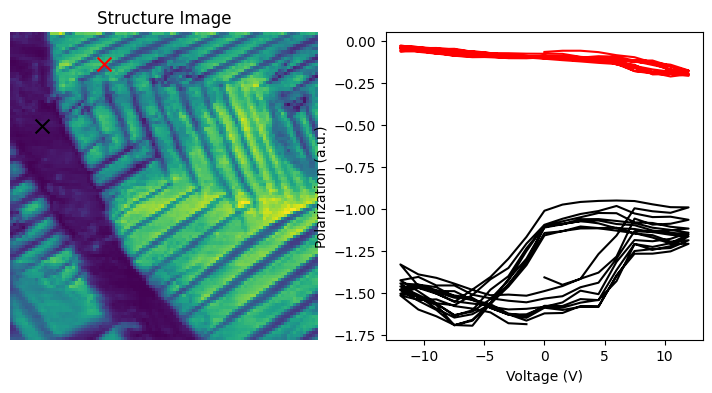

In [5]:
# select a region for exploration
exp_data = pola_off_field
img_data = amp_off_field
struc_img = img_data.mean(2)

# Visualize
plot_pixx1, plot_pixy1 = 10, 30
plot_pixx2, plot_pixy2 = 30, 10

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.imshow(struc_img)
ax1.scatter(plot_pixx1, plot_pixy1, marker='x', s=100, c='k')
ax1.scatter(plot_pixx2, plot_pixy2, marker='x', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.plot(v_step, exp_data[plot_pixx1, plot_pixy1], c='k')
ax2.plot(v_step, exp_data[plot_pixx2, plot_pixy2], c='r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Polarization (a.u.)')

plt.show()

In [6]:
# Extract image patches and spectra
img = norm_(struc_img)
spectra = norm_(exp_data)

coordinates = get_grid_coords(img, step=1)
window_size = 24
features_all, coords, _ = get_subimages(img, coordinates, window_size)
features_all = features_all[:,:,:,0]
coords = np.array(coords, dtype=int)
targets = spectra[coords[:, 0], coords[:, 1]]

print('Coordinates shape:', coords.shape)
print('Image patches shape:', features_all.shape)
print('Spectra shape:', spectra.shape)
print('Target spectra shape:', targets.shape)

Coordinates shape: (5929, 2)
Image patches shape: (5929, 24, 24)
Spectra shape: (100, 100, 256)
Target spectra shape: (5929, 256)


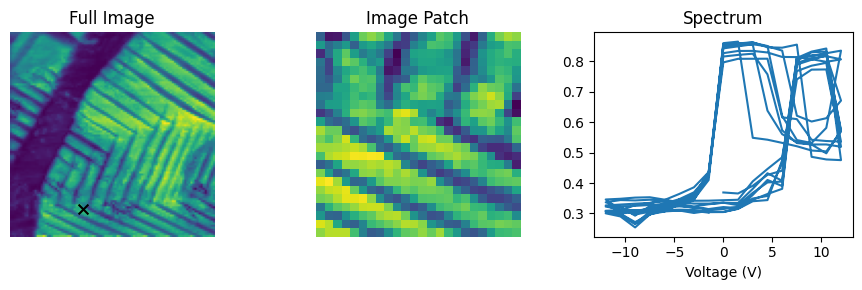

In [7]:
# Visualize example patch
k_example = 100
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
ax1.imshow(img, origin='lower')
ax1.scatter(coords[k_example, 1], coords[k_example, 0], marker='x', s=50, c='k')
ax1.axis("off")
ax1.set_title('Full Image')

ax2.imshow(features_all[k_example], origin='lower')
ax2.axis("off")
ax2.set_title('Image Patch')

ax3.plot(v_step, spectra[coords[k_example, 0], coords[k_example, 1]])
ax3.set_title('Spectrum')
ax3.set_xlabel('Voltage (V)')
plt.tight_layout()
plt.show()

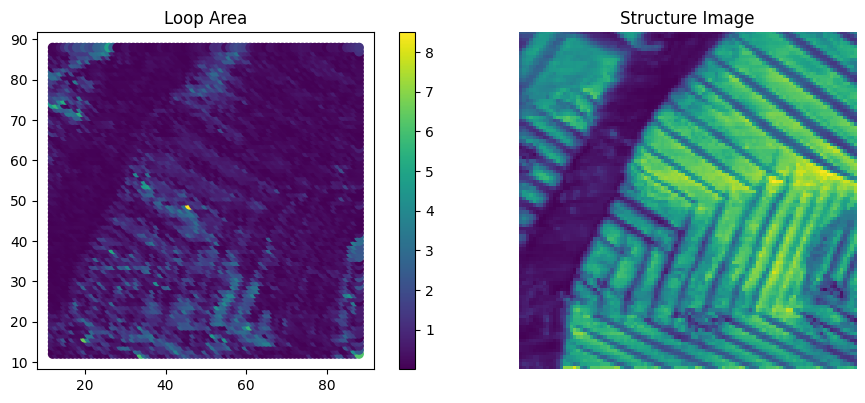

In [8]:
# Normalize and compute loop areas
features = norm_(features_all)
targets = norm_(targets)

loop_areas_all = []
for i, t in enumerate(targets):
    looparea = loop_area(t, 3)
    loop_areas_all.append(np.array([looparea]))

loop_areas_all = np.concatenate(loop_areas_all)

# Visualize loop areas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=loop_areas_all, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Loop Area')
ax1.set_aspect('equal')

ax2.imshow(struc_img, origin="lower")
ax2.set_title('Structure Image')
ax2.axis("off")
plt.tight_layout()
plt.show()

In [9]:
# Prepare data arrays
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  # Flattened patches for DKL
y = norm_(loop_areas_all)  # Scalarized values

print(f"X_train shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Coords shape: {coords.shape}")

X_train shape: (5929, 576)
y shape: (5929,)
Coords shape: (5929, 2)


In [10]:
# Select initial training points
np.random.seed(5)
start_size = 50
train_indices = np.random.choice(np.arange(1, n), size=start_size, replace=False)

X_train = X[train_indices]
y_train = y[train_indices]
coord_train = coords[train_indices]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Coordinates shape: {coord_train.shape}")

X_train shape: (50, 576)
y_train shape: (50,)
Coordinates shape: (50, 2)


In [11]:
# Train Deep Kernel GP
mll, gp_model, dkl_model1, losses = fit_dkgp(
    X_train,
    y_train,
    feature_dim=4,          
    extractor_type = 'direct_attention', 
    extractor_kwargs={'num_heads': 4},   
    num_epochs=2000,          # Training iterations
    verbose=True)

Training Deep Kernel GP Regression Model
Feature Extractor: direct_attention

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Extractor type: direct_attention
  Input dim: 576 → Feature dim: 4
  Data points: 50
  Hidden layers: [256, 128, 64]
  MLL: ExactMarginalLogLikelihood
  Epoch  100/2000, Loss: 0.3857
  Epoch  200/2000, Loss: -0.0938
  Epoch  300/2000, Loss: -0.5837
  Epoch  400/2000, Loss: -0.9994
  Epoch  500/2000, Loss: -1.4449
  Epoch  600/2000, Loss: -1.8615
  Epoch  700/2000, Loss: -2.2566
  Epoch  800/2000, Loss: -2.4509
  Epoch  900/2000, Loss: -2.6714
  Epoch 1000/2000, Loss: -2.7514
  Epoch 1100/2000, Loss: -2.9017
  Epoch 1200/2000, Loss: -2.7491
  Epoch 1300/2000, Loss: -2.7663
  Epoch 1400/2000, Loss: -2.9762
  Epoch 1500/2000, Loss: -2.6365
  Epoch 1600/2000, Loss: -3.0370
  Epoch 1700/2000, Loss: -2.9762
  Epoch 1800/2000, Loss: -2.9071
  Epoch 1900/2000, Loss: -2.9570
  Epoch 2000/2000, Loss: -2.9566
Training complete! Final loss

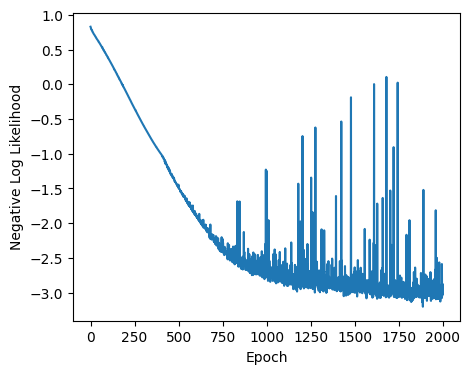

In [12]:
plt.figure(figsize=(5, 4))
plt.plot(losses,)
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')

plt.show()

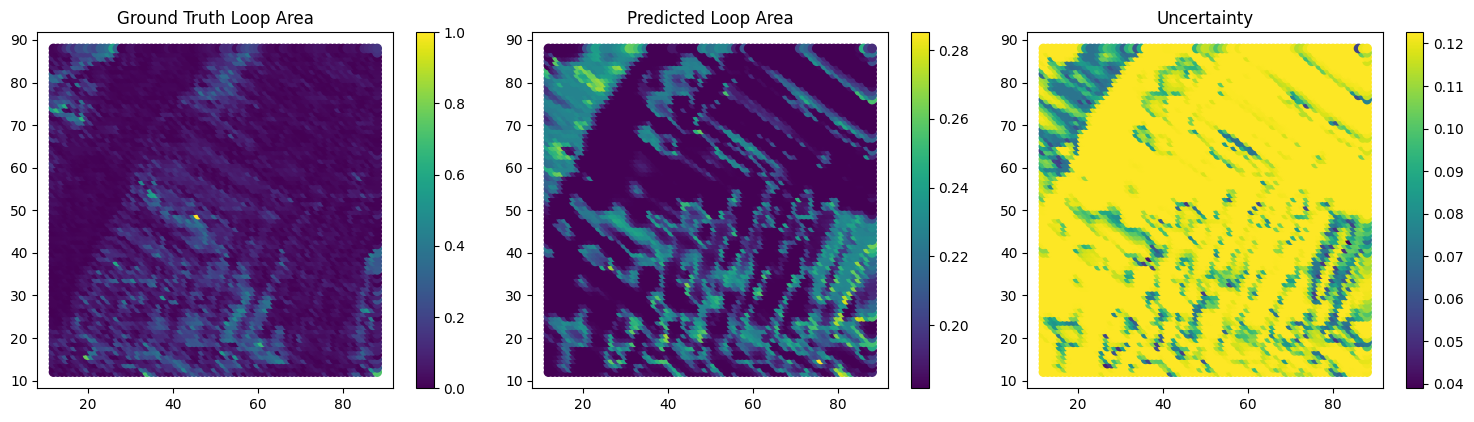

In [13]:
# Predict on test set
mean_pred, std_pred = predict_dkgpr(dkl_model1, X, return_std=True)
# Visualize predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=y, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Ground Truth Loop Area')
ax1.set_aspect('equal')

b=ax2.scatter(coords[:, 1], coords[:, 0], c=mean_pred, cmap='viridis')
ax2.set_title('Predicted Loop Area')
plt.colorbar(b, ax=ax2)
ax2.set_aspect('equal')

c=ax3.scatter(coords[:, 1], coords[:, 0], c=std_pred, cmap='viridis')
ax3.set_title('Uncertainty')
plt.colorbar(c, ax=ax3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In [14]:
# Get attention for one spectrum
x = X_train

# Extract attention map
attention_map = dkl_model1.feature_extractor.get_attention_map(
    torch.from_numpy(x).double()
)

print(attention_map.shape)  # (4, 256, 256)
# 4 heads, 256×256 wavelength relationships!

(50, 4, 4)


In [15]:
# Train Deep Kernel GP
mll, gp_model, dkl_model2, losses = fit_dkgp(
    X_train,
    y_train,
    feature_dim=2,          
    extractor_type = 'attention_weighted',    
    num_epochs=2000,
    verbose=True)

Training Deep Kernel GP Regression Model
Feature Extractor: attention_weighted

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Extractor type: attention_weighted
  Input dim: 576 → Feature dim: 2
  Data points: 50
  Hidden layers: [256, 128, 64]
  MLL: ExactMarginalLogLikelihood
  Epoch  100/2000, Loss: 0.3654
  Epoch  200/2000, Loss: -0.1235
  Epoch  300/2000, Loss: -0.6117
  Epoch  400/2000, Loss: -1.0973
  Epoch  500/2000, Loss: -1.5907
  Epoch  600/2000, Loss: -2.0316
  Epoch  700/2000, Loss: -2.3932
  Epoch  800/2000, Loss: -2.5807
  Epoch  900/2000, Loss: -2.7492
  Epoch 1000/2000, Loss: -2.8580
  Epoch 1100/2000, Loss: -2.9909
  Epoch 1200/2000, Loss: -3.0143
  Epoch 1300/2000, Loss: -3.1064
  Epoch 1400/2000, Loss: -3.1372
  Epoch 1500/2000, Loss: -3.1063
  Epoch 1600/2000, Loss: -3.1130
  Epoch 1700/2000, Loss: -3.1394
  Epoch 1800/2000, Loss: -3.2003
  Epoch 1900/2000, Loss: -3.1318
  Epoch 2000/2000, Loss: -3.2221
Training complete! Final 

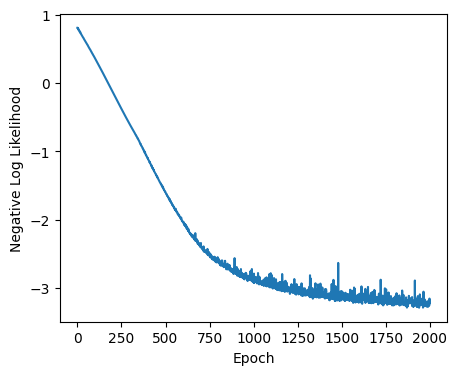

In [16]:
plt.figure(figsize=(5, 4))
plt.plot(losses,)
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')

plt.show()

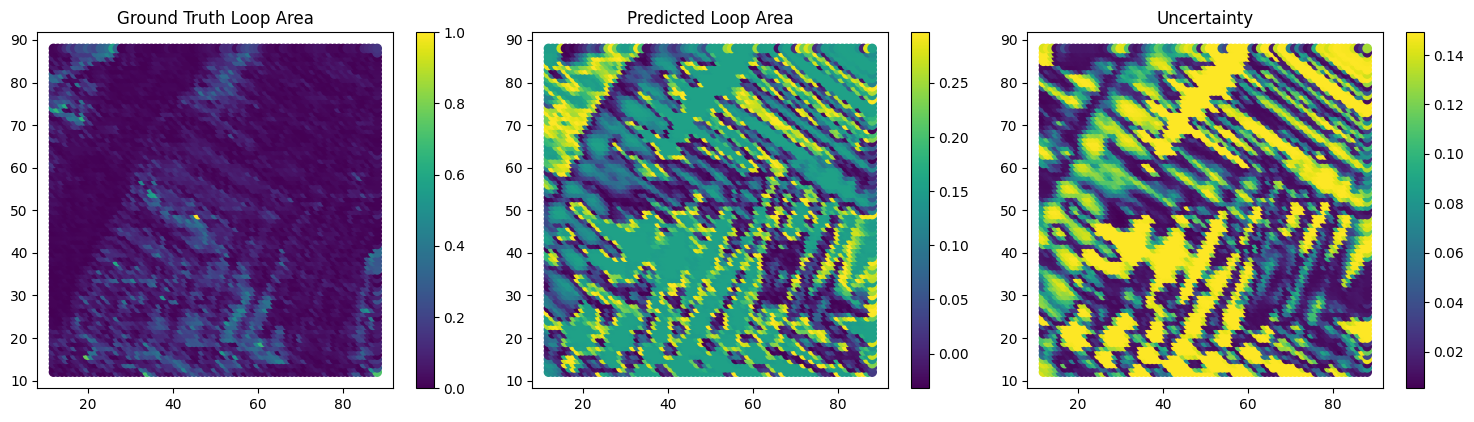

In [17]:
# Predict on test set
mean_pred, std_pred = predict_dkgpr(dkl_model2, X, return_std=True)
# Visualize predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=y, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Ground Truth Loop Area')
ax1.set_aspect('equal')

b=ax2.scatter(coords[:, 1], coords[:, 0], c=mean_pred, cmap='viridis')
ax2.set_title('Predicted Loop Area')
plt.colorbar(b, ax=ax2)
ax2.set_aspect('equal')

c=ax3.scatter(coords[:, 1], coords[:, 0], c=std_pred, cmap='viridis')
ax3.set_title('Uncertainty')
plt.colorbar(c, ax=ax3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In [18]:
weights = dkl_model2.feature_extractor.get_attention_weights(X_train)

In [19]:
weights[0].argmax()

np.int64(136)

In [20]:
xy = np.arange(24*24).reshape(24, 24)
x1, y1 = np.where(xy == weights[0].argmax())

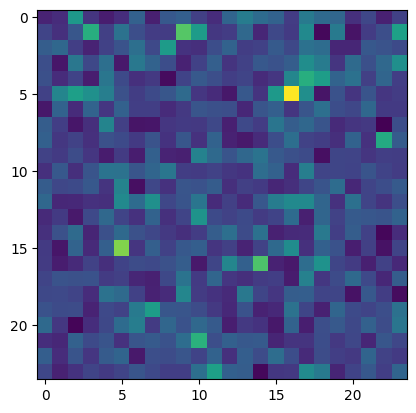

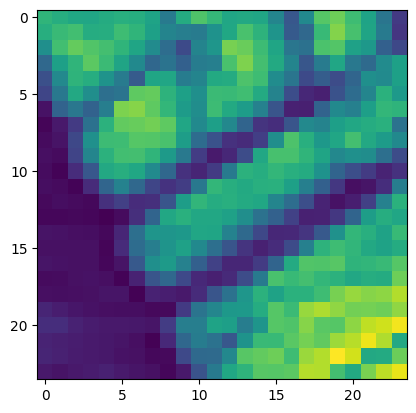

In [21]:
plt.imshow(weights[0].reshape(24, 24), cmap='viridis')
plt.show()
plt.imshow(X_train[0].reshape(24, 24), cmap='viridis')

In [42]:
# Train Deep Kernel GP
mll, gp_model, dkl_model, losses, sw = fit_dkgp(
    X_train,
    y_train,
    feature_dim=2,          
    extractor_type = 'fc', 
    learn_sample_weights=True,
    sample_weight_lr=0.0001,  
    num_epochs=2000,
    verbose=True)

Training Deep Kernel GP with Sample-Level Attention
Feature Extractor: fc
Sample Weighting: ENABLED (50 learnable weights)

Auto-selected: ExactMarginalLogLikelihood

Training Deep Kernel GP
  Device: cpu
  Extractor type: fc
  Input dim: 576 → Feature dim: 2
  Data points: 50
  Hidden layers: [256, 128, 64]
  MLL: SampleWeightedMLL
  Epoch  100/2000, Loss: 17.3917
  Epoch  200/2000, Loss: -4.7937
  Epoch  300/2000, Loss: -27.7432
  Epoch  400/2000, Loss: -49.4427
  Epoch  500/2000, Loss: -66.5194
  Epoch  600/2000, Loss: -72.4357
  Epoch  700/2000, Loss: -72.9615
  Epoch  800/2000, Loss: -73.2808
  Epoch  900/2000, Loss: -73.5567
  Epoch 1000/2000, Loss: -73.8057
  Epoch 1100/2000, Loss: -74.0364
  Epoch 1200/2000, Loss: -74.2540
  Epoch 1300/2000, Loss: -74.4616
  Epoch 1400/2000, Loss: -74.6616
  Epoch 1500/2000, Loss: -74.8554
  Epoch 1600/2000, Loss: -75.0443
  Epoch 1700/2000, Loss: -75.2291
  Epoch 1800/2000, Loss: -75.4106
  Epoch 1900/2000, Loss: -75.5893
  Epoch 2000/2000, Lo

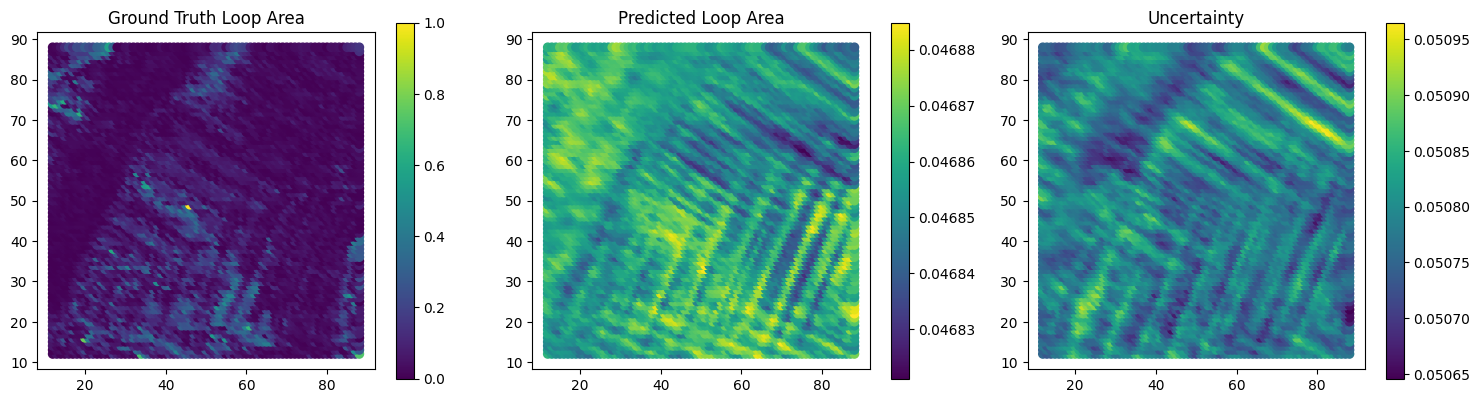

In [47]:
# Predict on test set
mean_pred, std_pred = predict_dkgpr(dkl_model, X, return_std=True)
# Visualize predictions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
a = ax1.scatter(coords[:, 1], coords[:, 0], c=y, cmap='viridis')
plt.colorbar(a, ax=ax1)
ax1.set_title('Ground Truth Loop Area')
ax1.set_aspect('equal')

b=ax2.scatter(coords[:, 1], coords[:, 0], c=mean_pred, cmap='viridis')
ax2.set_title('Predicted Loop Area')
plt.colorbar(b, ax=ax2)
ax2.set_aspect('equal')

c=ax3.scatter(coords[:, 1], coords[:, 0], c=std_pred, cmap='viridis')
ax3.set_title('Uncertainty')
plt.colorbar(c, ax=ax3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

In [48]:
sw

array([0.75191957, 1.03853914, 1.04172306, 1.04065442, 1.04181309,
       1.04050665, 1.03948027, 1.04187415, 1.03939167, 1.04140293,
       1.04168253, 1.04187857, 1.04178423, 1.0418248 , 1.0387532 ,
       1.04167994, 1.04170078, 1.04178932, 1.03927107, 0.75563454,
       1.04097287, 1.0417418 , 0.75215343, 1.04173604, 1.04110921,
       1.03993269, 0.75460399, 1.0418044 , 1.03920565, 0.75366901,
       1.04110666, 0.99461644, 1.04179668, 1.04187672, 0.75532736,
       1.04177848, 1.03941064, 0.75500893, 1.04111821, 1.04186925,
       1.04187837, 1.04180113, 1.041854  , 1.04170959, 1.04171631,
       1.04185147, 1.04171301, 1.04059563, 1.04108741, 1.04165072])

In [49]:
sw.argsort()

array([ 0, 22, 29, 26, 37, 34, 19, 31,  1, 14, 28, 18,  8, 36,  6, 25,  5,
       47,  3, 20, 48, 30, 24, 38,  9, 49, 15, 10, 16, 43, 46, 44,  2, 23,
       21, 35, 12, 17, 32, 41, 27,  4, 13, 45, 42, 39,  7, 33, 40, 11])

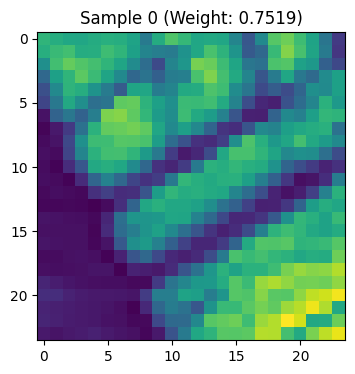

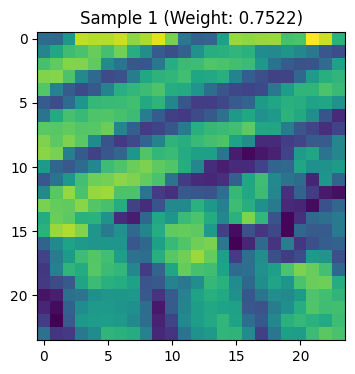

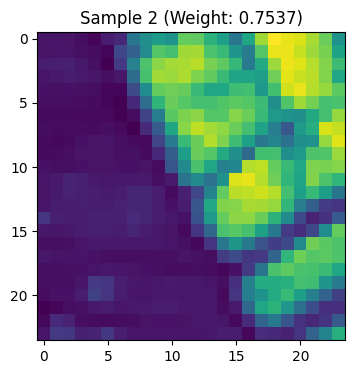

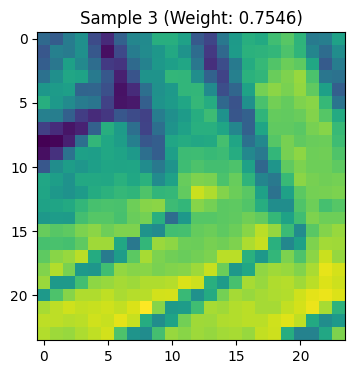

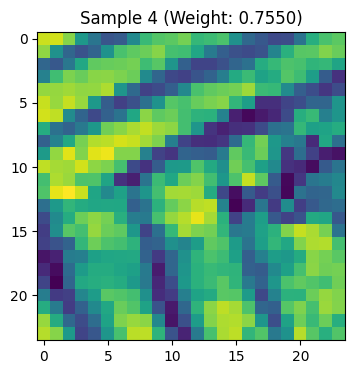

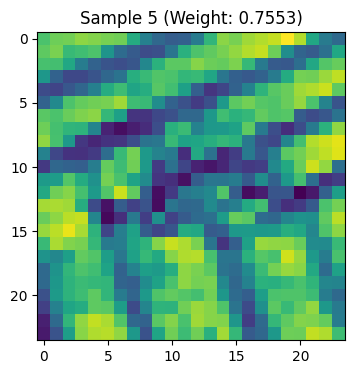

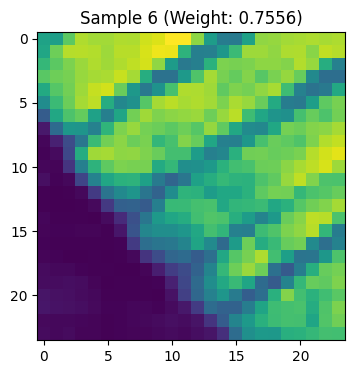

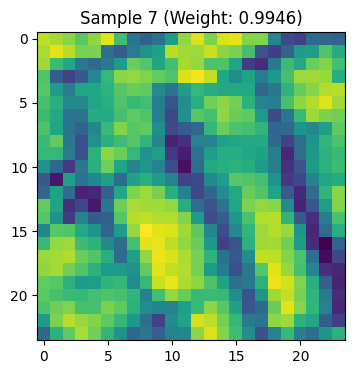

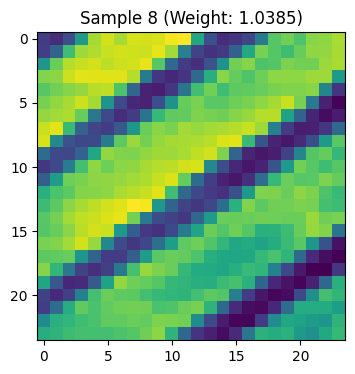

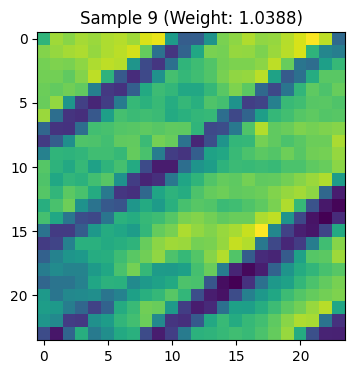

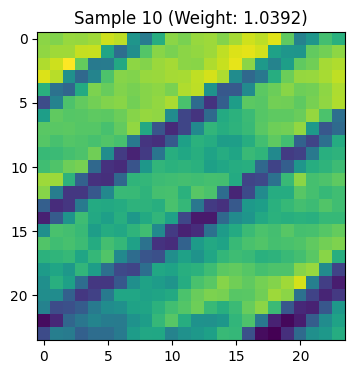

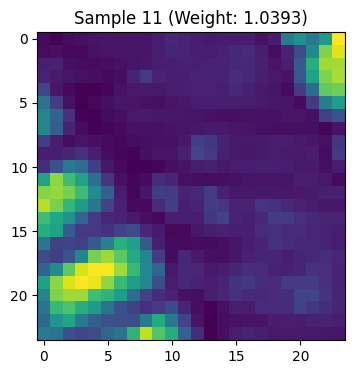

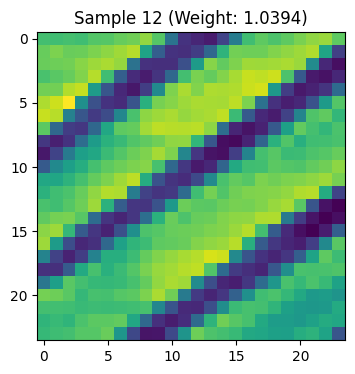

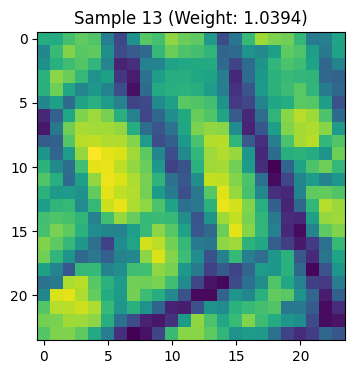

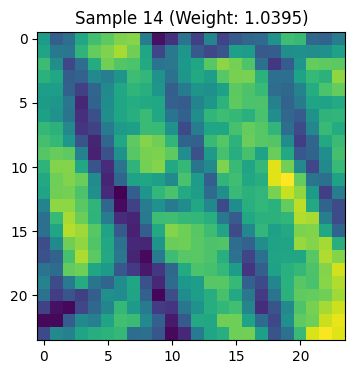

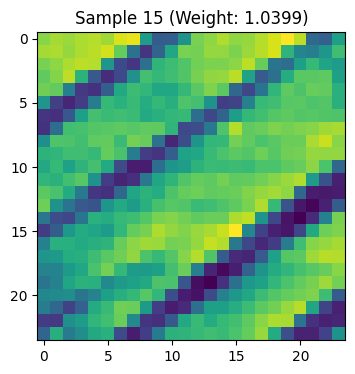

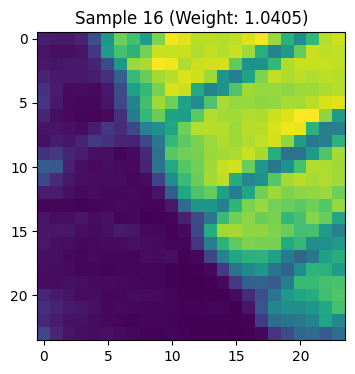

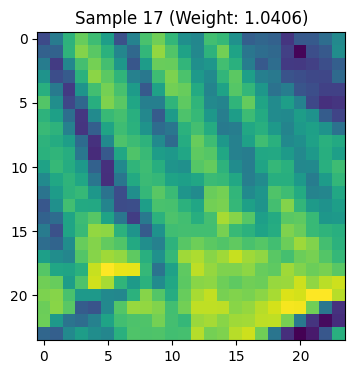

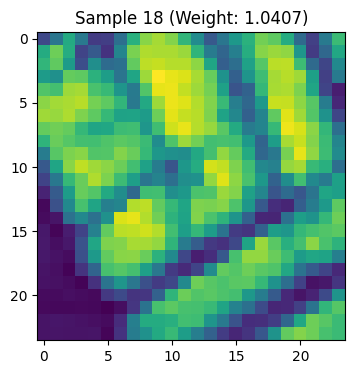

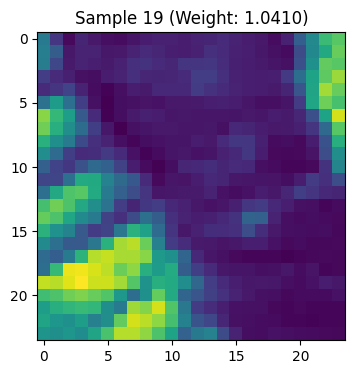

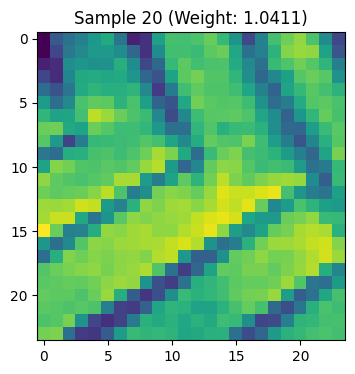

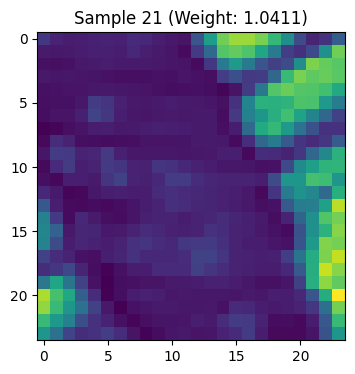

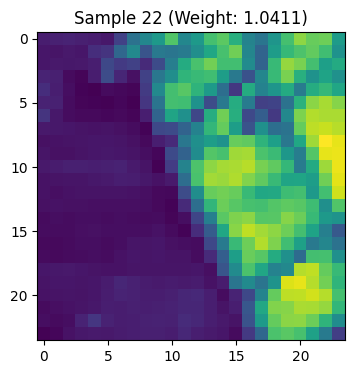

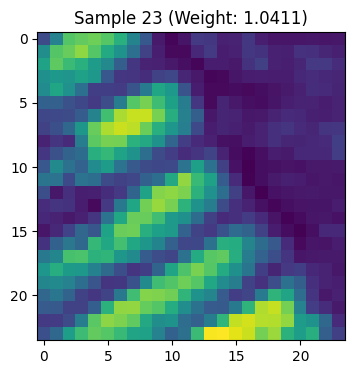

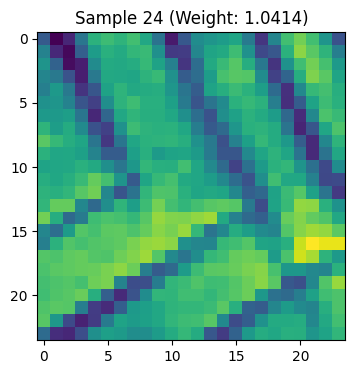

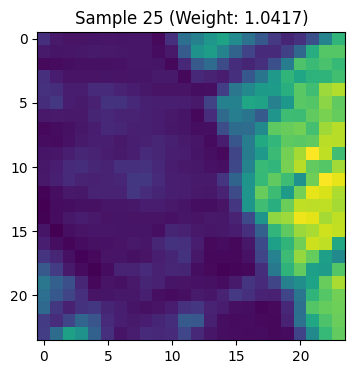

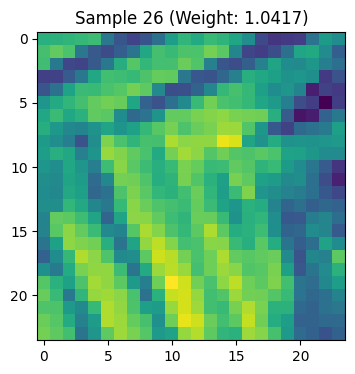

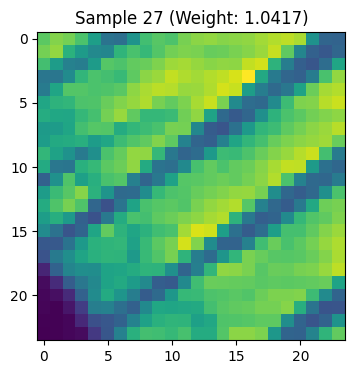

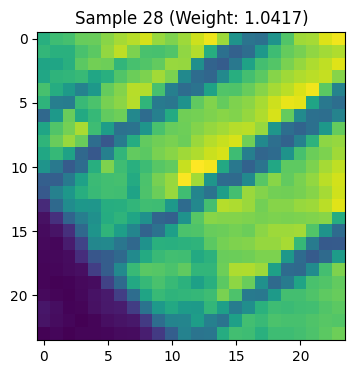

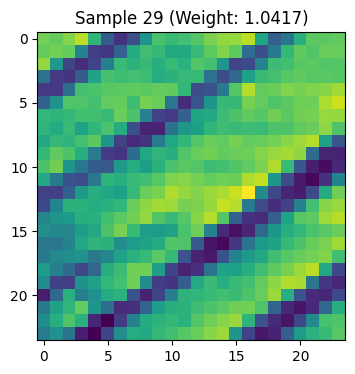

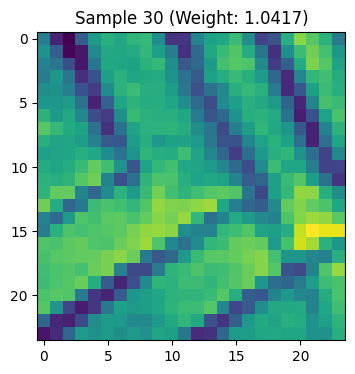

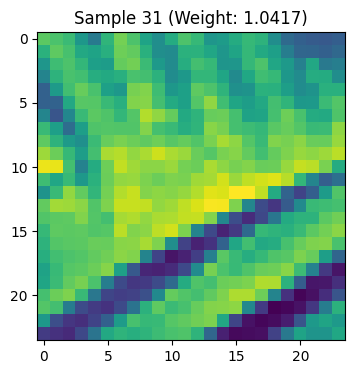

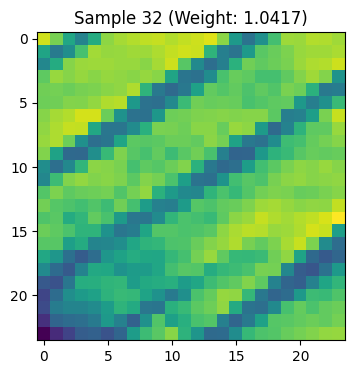

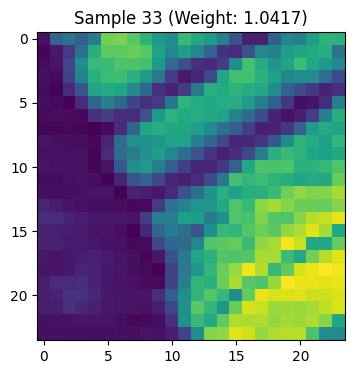

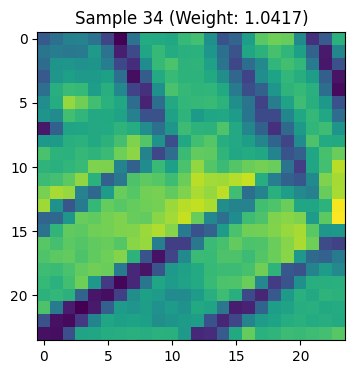

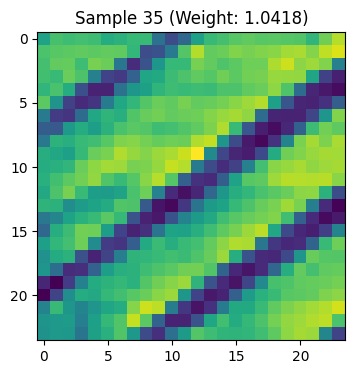

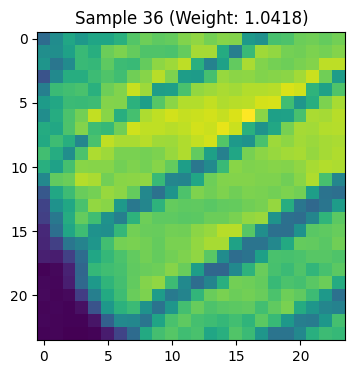

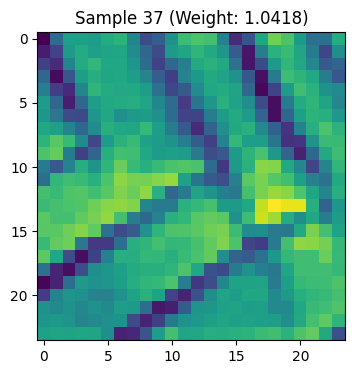

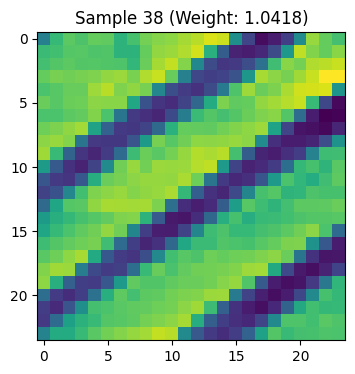

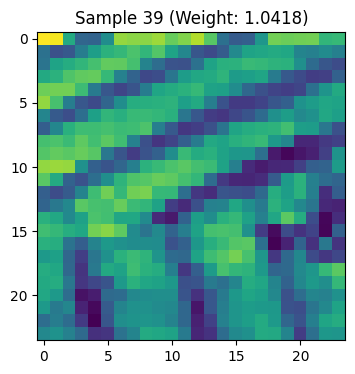

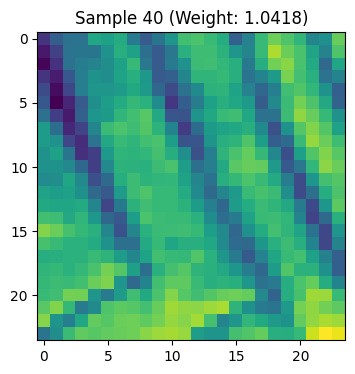

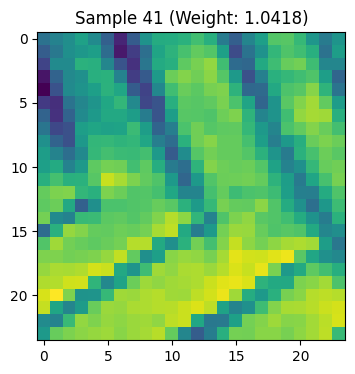

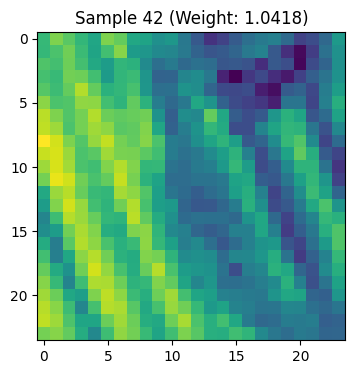

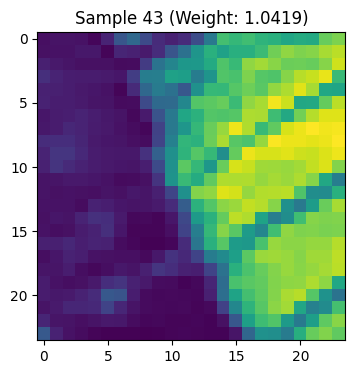

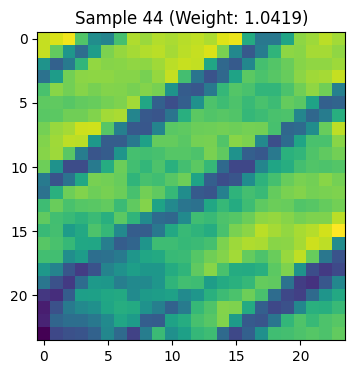

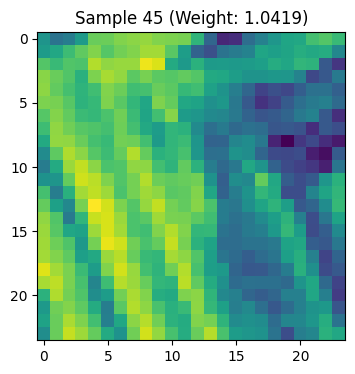

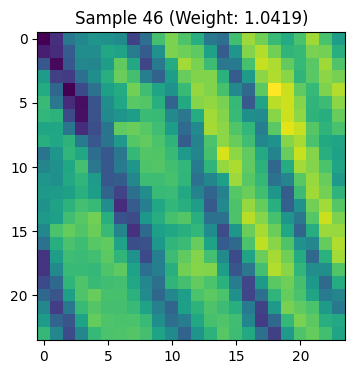

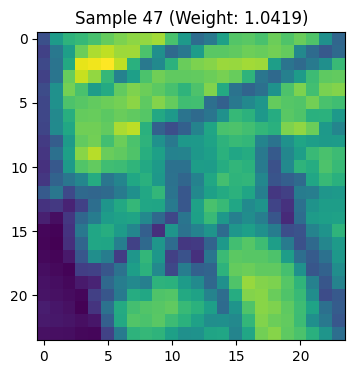

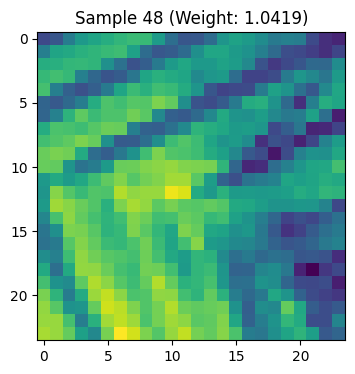

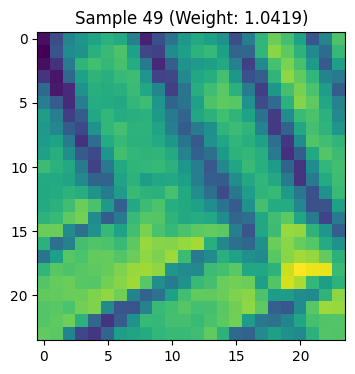

In [50]:
sw_idx = sw.argsort()
for i in range (len(sw)):
    plt.figure(figsize=(5, 4))
    plt.imshow(X_train[sw_idx[i]].reshape(24, 24), cmap='viridis')
    plt.title(f"Sample {i} (Weight: {sw[sw_idx[i]]:.4f})")
    plt.show()

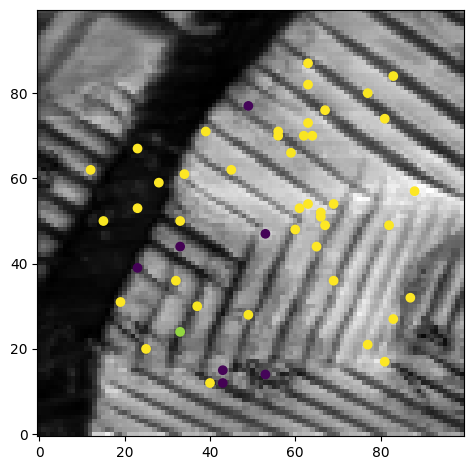

In [53]:
plt.figure()
plt.imshow(struc_img, origin="lower", cmap = "gray")
plt.scatter(coord_train[:, 1], coord_train[:, 0], c=sw, cmap='viridis')
plt.tight_layout()
plt.show()